In [1]:
import tensorflow as tf
import sys
sys.path.append("../../")
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import abc
import time
import six
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    mean_squared_error,
    accuracy_score,
    f1_score,
)
import yaml
import zipfile

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def cal_metric(labels, preds, metrics):
    """Calculate metrics,such as auc, logloss.
    
    FIXME: 
        refactor this with the reco metrics and make it explicit.
    """
    res = {}
    for metric in metrics:
        if metric == "auc":
            auc = roc_auc_score(np.asarray(labels), np.asarray(preds))
            res["auc"] = round(auc, 4)
        elif metric == "rmse":
            rmse = mean_squared_error(np.asarray(labels), np.asarray(preds))
            res["rmse"] = np.sqrt(round(rmse, 4))
        elif metric == "logloss":
            # avoid logloss nan
            preds = [max(min(p, 1.0 - 10e-12), 10e-12) for p in preds]
            logloss = log_loss(np.asarray(labels), np.asarray(preds))
            res["logloss"] = round(logloss, 4)
        elif metric == "acc":
            pred = np.asarray(preds)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            acc = accuracy_score(np.asarray(labels), pred)
            res["acc"] = round(acc, 4)
        elif metric == "f1":
            pred = np.asarray(preds)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            f1 = f1_score(np.asarray(labels), pred)
            res["f1"] = round(f1, 4)
        else:
            raise ValueError("not define this metric {0}".format(metric))
    return res

In [3]:

__all__ = ["BaseModel"]
class BaseModel:
    def __init__(self, hparams, iterator_creator, graph=None, seed=None):
        """Initializing the model. Create common logics which are needed by all deeprec models, such as loss function, 
        parameter set.
        Args:
            hparams (obj): A tf.contrib.training.HParams object, hold the entire set of hyperparameters.
            iterator_creator (obj): An iterator to load the data.
            graph (obj): An optional graph.
            seed (int): Random seed.
        """
        self.seed = seed
        tf.set_random_seed(seed)
        np.random.seed(seed)

        self.graph = graph if graph is not None else tf.Graph()
        self.iterator = iterator_creator(hparams, self.graph)

        with self.graph.as_default():
            self.hparams = hparams

            self.layer_params = []
            self.embed_params = []
            self.cross_params = []
            self.layer_keeps = tf.placeholder(tf.float32, name="layer_keeps")
            self.keep_prob_train = None
            self.keep_prob_test = None
            self.is_train_stage = tf.placeholder(tf.bool, shape=(), name="is_training")

            self.initializer = self._get_initializer()

            self.logit = self._build_graph()
            self.pred = self._get_pred(self.logit, self.hparams.method)

            self.loss = self._get_loss()
            self.saver = tf.train.Saver(max_to_keep=self.hparams.epochs)
            self.update = self._build_train_opt()
            self.init_op = tf.global_variables_initializer()
            self.merged = self._add_summaries()

        # set GPU use with demand growth
        gpu_options = tf.GPUOptions(allow_growth=True)
        self.sess = tf.Session(
            graph=self.graph, config=tf.ConfigProto(gpu_options=gpu_options)
        )
        self.sess.run(self.init_op)

    @abc.abstractmethod
    def _build_graph(self):
        """Subclass will implement this."""
        pass

    def _get_loss(self):
        """Make loss function, consists of data loss and regularization loss
        
        Returns:
            obj: Loss value
        """
        self.data_loss = self._compute_data_loss()
        self.regular_loss = self._compute_regular_loss()
        self.loss = tf.add(self.data_loss, self.regular_loss)
        return self.loss

    def _get_pred(self, logit, task):
        """Make final output as prediction score, according to different tasks.
        
        Args:
            logit (obj): Base prediction value.
            task (str): A task (values: regression/classification)
        
        Returns:
            obj: Transformed score
        """
        if task == "regression":
            pred = tf.identity(logit)
        elif task == "classification":
            pred = tf.sigmoid(logit)
        else:
            raise ValueError(
                "method must be regression or classification, but now is {0}".format(
                    task
                )
            )
        return pred

    def _add_summaries(self):
        tf.summary.scalar("data_loss", self.data_loss)
        tf.summary.scalar("regular_loss", self.regular_loss)
        tf.summary.scalar("loss", self.loss)
        merged = tf.summary.merge_all()
        return merged

    def _l2_loss(self):
        l2_loss = tf.zeros([1], dtype=tf.float32)
        # embedding_layer l2 loss
        for param in self.embed_params:
            l2_loss = tf.add(
                l2_loss, tf.multiply(self.hparams.embed_l2, tf.nn.l2_loss(param))
            )
        params = self.layer_params
        for param in params:
            l2_loss = tf.add(
                l2_loss, tf.multiply(self.hparams.layer_l2, tf.nn.l2_loss(param))
            )
        return l2_loss

    def _l1_loss(self):
        l1_loss = tf.zeros([1], dtype=tf.float32)
        # embedding_layer l2 loss
        for param in self.embed_params:
            l1_loss = tf.add(
                l1_loss, tf.multiply(self.hparams.embed_l1, tf.norm(param, ord=1))
            )
        params = self.layer_params
        for param in params:
            l1_loss = tf.add(
                l1_loss, tf.multiply(self.hparams.layer_l1, tf.norm(param, ord=1))
            )
        return l1_loss

    def _cross_l_loss(self):
        """Construct L1-norm and L2-norm on cross network parameters for loss function.
        Returns:
            obj: Regular loss value on cross network parameters.
        """
        cross_l_loss = tf.zeros([1], dtype=tf.float32)
        for param in self.cross_params:
            cross_l_loss = tf.add(
                cross_l_loss, tf.multiply(self.hparams.cross_l1, tf.norm(param, ord=1))
            )
            cross_l_loss = tf.add(
                cross_l_loss, tf.multiply(self.hparams.cross_l2, tf.norm(param, ord=2))
            )
        return cross_l_loss

    def _get_initializer(self):
        if self.hparams.init_method == "tnormal":
            return tf.truncated_normal_initializer(stddev=self.hparams.init_value, seed=self.seed)
        elif self.hparams.init_method == "uniform":
            return tf.random_uniform_initializer(
                -self.hparams.init_value, self.hparams.init_value, seed=self.seed
            )
        elif self.hparams.init_method == "normal":
            return tf.random_normal_initializer(stddev=self.hparams.init_value, seed=self.seed)
        elif self.hparams.init_method == "xavier_normal":
            return tf.contrib.layers.xavier_initializer(uniform=False, seed=self.seed)
        elif self.hparams.init_method == "xavier_uniform":
            return tf.contrib.layers.xavier_initializer(uniform=True, seed=self.seed)
        elif self.hparams.init_method == "he_normal":
            return tf.contrib.layers.variance_scaling_initializer(
                factor=2.0, mode="FAN_IN", uniform=False, seed=self.seed
            )
        elif self.hparams.init_method == "he_uniform":
            return tf.contrib.layers.variance_scaling_initializer(
                factor=2.0, mode="FAN_IN", uniform=True, seed=self.seed
            )
        else:
            return tf.truncated_normal_initializer(stddev=self.hparams.init_value, seed=self.seed)

    def _compute_data_loss(self):
        if self.hparams.loss == "cross_entropy_loss":
            data_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=tf.reshape(self.logit, [-1]),
                    labels=tf.reshape(self.iterator.labels, [-1]),
                )
            )
        elif self.hparams.loss == "square_loss":
            data_loss = tf.sqrt(
                tf.reduce_mean(
                    tf.squared_difference(
                        tf.reshape(self.pred, [-1]),
                        tf.reshape(self.iterator.labels, [-1]),
                    )
                )
            )
        elif self.hparams.loss == "log_loss":
            data_loss = tf.reduce_mean(
                tf.losses.log_loss(
                    predictions=tf.reshape(self.pred, [-1]),
                    labels=tf.reshape(self.iterator.labels, [-1]),
                )
            )
        
        else:
            raise ValueError("this loss not defined {0}".format(self.hparams.loss))
        return data_loss

    def _compute_regular_loss(self):
        """Construct regular loss. Usually it's comprised of l1 and l2 norm.
        Users can designate which norm to be included via config file.
        Returns:
            obj: Regular loss.
        """
        regular_loss = self._l2_loss() + self._l1_loss() + self._cross_l_loss()
        return tf.reduce_sum(regular_loss)

    def _train_opt(self):
        """Get the optimizer according to configuration. Usually we will use Adam.
        Returns:
            obj: An optimizer.
        """
        lr = self.hparams.learning_rate
        optimizer = self.hparams.optimizer

        if optimizer == "adadelta":
            train_step = tf.train.AdadeltaOptimizer(lr)
        elif optimizer == "adagrad":
            train_step = tf.train.AdagradOptimizer(lr)
        elif optimizer == "sgd":
            train_step = tf.train.GradientDescentOptimizer(lr)
        elif optimizer == "adam":
            train_step = tf.train.AdamOptimizer(lr)
        elif optimizer == "ftrl":
            train_step = tf.train.FtrlOptimizer(lr)
        elif optimizer == "gd":
            train_step = tf.train.GradientDescentOptimizer(lr)
        elif optimizer == "padagrad":
            train_step = tf.train.ProximalAdagradOptimizer(lr)  # .minimize(self.loss)
        elif optimizer == "pgd":
            train_step = tf.train.ProximalGradientDescentOptimizer(lr)
        elif optimizer == "rmsprop":
            train_step = tf.train.RMSPropOptimizer(lr)
        else:
            train_step = tf.train.GradientDescentOptimizer(lr)
        return train_step

    def _build_train_opt(self):
        """Construct gradient descent based optimization step
        In this step, we provide gradient clipping option. Sometimes we what to clip the gradients
        when their absolute values are too large to avoid gradient explosion.
        Returns:
            obj: An operation that applies the specified optimization step.
        """
        train_step = self._train_opt()
        gradients, variables = zip(*train_step.compute_gradients(self.loss))
        if self.hparams.is_clip_norm:
            gradients = [
                None
                if gradient is None
                else tf.clip_by_norm(gradient, self.hparams.max_grad_norm)
                for gradient in gradients
            ]
        return train_step.apply_gradients(zip(gradients, variables))

    def _active_layer(self, logit, activation, layer_idx=-1):
        """Transform the input value with an activation. May use dropout.
        
        Args:
            logit (obj): Input value.
            activation (str): A string indicating the type of activation function.
            layer_idx (int): Index of current layer. Used to retrieve corresponding parameters
        
        Returns:
            obj: A tensor after applying activation function on logit.
        """
        if layer_idx >= 0 and self.hparams.user_dropout:
            logit = self._dropout(logit, self.layer_keeps[layer_idx])
        return self._activate(logit, activation)

    def _activate(self, logit, activation):
        if activation == "sigmoid":
            return tf.nn.sigmoid(logit)
        elif activation == "softmax":
            return tf.nn.softmax(logit)
        elif activation == "relu":
            return tf.nn.relu(logit)
        elif activation == "tanh":
            return tf.nn.tanh(logit)
        elif activation == "elu":
            return tf.nn.elu(logit)
        elif activation == "identity":
            return tf.identity(logit)
        else:
            raise ValueError("this activations not defined {0}".format(activation))

    def _dropout(self, logit, keep_prob):
        """Apply drops upon the input value.
        Args:
            logit (obj): The input value.
            keep_prob (float): The probability of keeping each element.
        Returns:
            obj: A tensor of the same shape of logit.
        """
        return tf.nn.dropout(x=logit, keep_prob=keep_prob)

    def train(self, sess, feed_dict):
        """Go through the optimization step once with training data in feed_dict.
        Args:
            sess (obj): The model session object.
            feed_dict (dict): Feed values to train the model. This is a dictionary that maps graph elements to values.
        Returns:
            list: A list of values, including update operation, total loss, data loss, and merged summary.
        """
        feed_dict[self.layer_keeps] = self.keep_prob_train
        feed_dict[self.is_train_stage] = True
        return sess.run(
            [self.update, self.loss, self.data_loss, self.merged], feed_dict=feed_dict
        )

    def eval(self, sess, feed_dict):
        """Evaluate the data in feed_dict with current model.
        Args:
            sess (obj): The model session object.
            feed_dict (dict): Feed values for evaluation. This is a dictionary that maps graph elements to values.
        Returns:
            list: A list of evaluated results, including total loss value, data loss value,
                predicted scores, and ground-truth labels.
        """
        feed_dict[self.layer_keeps] = self.keep_prob_test
        feed_dict[self.is_train_stage] = False
        return sess.run(
            [self.loss, self.data_loss, self.pred, self.iterator.labels],
            feed_dict=feed_dict,
        )

    def infer(self, sess, feed_dict):
        """Given feature data (in feed_dict), get predicted scores with current model.
        Args:
            sess (obj): The model session object.
            feed_dict (dict): Instances to predict. This is a dictionary that maps graph elements to values.
        Returns:
            list: Predicted scores for the given instances.
        """
        feed_dict[self.layer_keeps] = self.keep_prob_test
        feed_dict[self.is_train_stage] = False
        return sess.run([self.pred], feed_dict=feed_dict)

    def load_model(self, model_path=None):
        """Load an existing model.
        Args:
            model_path: model path.
        Raises:
            IOError: if the restore operation failed.
        """
        act_path = self.hparams.load_saved_model
        if model_path is not None:
            act_path = model_path

        try:
            self.saver.restore(self.sess, act_path)
        except:
            raise IOError("Failed to find any matching files for {0}".format(act_path))

    def fit(self, train_file, valid_file, test_file=None):
        """Fit the model with train_file. Evaluate the model on valid_file per epoch to observe the training status.
        If test_file is not None, evaluate it too.
        
        Args:
            train_file (str): training data set.
            valid_file (str): validation set.
            test_file (str): test set.
        Returns:
            obj: An instance of self.
        """
        if self.hparams.write_tfevents:
            self.writer = tf.summary.FileWriter(
                self.hparams.SUMMARIES_DIR, self.sess.graph
            )

        train_sess = self.sess
        for epoch in range(1, self.hparams.epochs + 1):
            step = 0
            self.hparams.current_epoch = epoch

            epoch_loss = 0
            train_start = time.time()
            for batch_data_input in self.iterator.load_data_from_file(train_file):
                step_result = self.train(train_sess, batch_data_input)
                (_, step_loss, step_data_loss, summary) = step_result
                if self.hparams.write_tfevents:
                    self.writer.add_summary(summary, step)
                epoch_loss += step_loss
                step += 1
                if step % self.hparams.show_step == 0:
                    print(
                        "step {0:d} , total_loss: {1:.4f}, data_loss: {2:.4f}".format(
                            step, step_loss, step_data_loss
                        )
                    )

            train_end = time.time()
            train_time = train_end - train_start

            if self.hparams.save_model:
                if epoch % self.hparams.save_epoch == 0:
                    checkpoint_path = self.saver.save(
                        sess=train_sess,
                        save_path=self.hparams.MODEL_DIR + "epoch_" + str(epoch),
                    )

            eval_start = time.time()
            train_res = self.run_eval(train_file)
            eval_res = self.run_eval(valid_file)
            train_info = ", ".join(
                [
                    str(item[0]) + ":" + str(item[1])
                    for item in sorted(train_res.items(), key=lambda x: x[0])
                ]
            )
            eval_info = ", ".join(
                [
                    str(item[0]) + ":" + str(item[1])
                    for item in sorted(eval_res.items(), key=lambda x: x[0])
                ]
            )
            if test_file is not None:
                test_res = self.run_eval(test_file)
                test_info = ", ".join(
                    [
                        str(item[0]) + ":" + str(item[1])
                        for item in sorted(test_res.items(), key=lambda x: x[0])
                    ]
                )
            eval_end = time.time()
            eval_time = eval_end - eval_start

            if test_file is not None:
                print(
                    "at epoch {0:d}".format(epoch)
                    + " train info: "
                    + train_info
                    + " eval info: "
                    + eval_info
                    + " test info: "
                    + test_info
                )
            else:
                print(
                    "at epoch {0:d}".format(epoch)
                    + " train info: "
                    + train_info
                    + " eval info: "
                    + eval_info
                )
            print(
                "at epoch {0:d} , train time: {1:.1f} eval time: {2:.1f}".format(
                    epoch, train_time, eval_time
                )
            )

        if self.hparams.write_tfevents:
            self.writer.close()

        return self

    def run_eval(self, filename):
        """Evaluate the given file and returns some evaluation metrics.
        
        Args:
            filename (str): A file name that will be evaluated.
        Returns:
            dict: A dictionary contains evaluation metrics.
        """
        load_sess = self.sess
        preds = []
        labels = []
        for batch_data_input in self.iterator.load_data_from_file(filename):
            _, _, step_pred, step_labels = self.eval(load_sess, batch_data_input)
            preds.extend(np.reshape(step_pred, -1))
            labels.extend(np.reshape(step_labels, -1))
        res = cal_metric(labels, preds, self.hparams.metrics)
        return res

    def predict(self, infile_name, outfile_name):
        """Make predictions on the given data, and output predicted scores to a file.
        
        Args:
            infile_name (str): Input file name.
            outfile_name (str): Output file name.
        Returns:
            obj: An instance of self.
        """
        load_sess = self.sess
        preds = []
        with tf.gfile.GFile(outfile_name, "w") as wt:
            for batch_data_input in self.iterator.load_data_from_file(infile_name):
                step_pred = self.infer(load_sess, batch_data_input)
                step_pred = np.reshape(step_pred, -1)
                preds.extend(step_pred)
                wt.write("\n".join(map(str, step_pred)))
                # line break after each batch.
                wt.write("\n")
        return preds

In [4]:
__all__ = ["XDeepFMModel"]


class XDeepFMModel(BaseModel):
    def _build_graph(self):
        """The main function to create xdeepfm's logic.
        
        Returns:
            obj:the prediction score make by the model.
        """
        hparams = self.hparams
        self.keep_prob_train = 1 - np.array(hparams.dropout)
        self.keep_prob_test = np.ones_like(hparams.dropout)

        with tf.variable_scope("XDeepFM") as scope:
            with tf.variable_scope("embedding", initializer=self.initializer) as escope:
                self.embedding = tf.get_variable(
                    name="embedding_layer",
                    shape=[hparams.FEATURE_COUNT, hparams.dim],
                    dtype=tf.float32,
                )
                self.embed_params.append(self.embedding)
                embed_out, embed_layer_size = self._build_embedding()

            logit = 0

            if hparams.use_Linear_part:
                print("Add linear part.")
                logit = logit + self._build_linear()

            if hparams.use_FM_part:
                print("Add FM part.")
                logit = logit + self._build_fm()

            if hparams.use_CIN_part:
                print("Add CIN part.")
                if hparams.fast_CIN_d <= 0:
                    logit = logit + self._build_CIN(
                        embed_out, res=True, direct=False, bias=False, is_masked=True
                    )
                else:
                    logit = logit + self._build_fast_CIN(
                        embed_out, res=True, direct=False, bias=False
                    )

            if hparams.use_DNN_part:
                print("Add DNN part.")
                logit = logit + self._build_dnn(embed_out, embed_layer_size)

            return logit

    def _build_embedding(self):
        """The field embedding layer. MLP requires fixed-length vectors as input.
        This function makes sum pooling of feature embeddings for each field.
        
        Returns:
            embedding:  the result of field embedding layer, with size of #_fields * #_dim
            embedding_size: #_fields * #_dim
        """
        hparams = self.hparams
        fm_sparse_index = tf.SparseTensor(
            self.iterator.dnn_feat_indices,
            self.iterator.dnn_feat_values,
            self.iterator.dnn_feat_shape,
        )
        fm_sparse_weight = tf.SparseTensor(
            self.iterator.dnn_feat_indices,
            self.iterator.dnn_feat_weights,
            self.iterator.dnn_feat_shape,
        )
        w_fm_nn_input_orgin = tf.nn.embedding_lookup_sparse(
            self.embedding, fm_sparse_index, fm_sparse_weight, combiner="sum"
        )
        embedding = tf.reshape(
            w_fm_nn_input_orgin, [-1, hparams.dim * hparams.FIELD_COUNT]
        )
        embedding_size = hparams.FIELD_COUNT * hparams.dim
        return embedding, embedding_size

    def _build_linear(self):
        """Construct the linear part for the model.
        This is a linear regression.
        
        Returns:
            obj: prediction score made by linear regression.
        """
        with tf.variable_scope("linear_part", initializer=self.initializer) as scope:
            w = tf.get_variable(
                name="w", shape=[self.hparams.FEATURE_COUNT, 1], dtype=tf.float32
            )
            b = tf.get_variable(
                name="b",
                shape=[1],
                dtype=tf.float32,
                initializer=tf.zeros_initializer(),
            )
            x = tf.SparseTensor(
                self.iterator.fm_feat_indices,
                self.iterator.fm_feat_values,
                self.iterator.fm_feat_shape,
            )
            linear_output = tf.add(tf.sparse_tensor_dense_matmul(x, w), b)
            self.layer_params.append(w)
            self.layer_params.append(b)
            tf.summary.histogram("linear_part/w", w)
            tf.summary.histogram("linear_part/b", b)
            return linear_output

    def _build_fm(self):
        """Construct the factorization machine part for the model.
        This is a traditional 2-order FM module.
        
        Returns:
            obj: prediction score made by factorization machine.
        """
        with tf.variable_scope("fm_part") as scope:
            x = tf.SparseTensor(
                self.iterator.fm_feat_indices,
                self.iterator.fm_feat_values,
                self.iterator.fm_feat_shape,
            )
            xx = tf.SparseTensor(
                self.iterator.fm_feat_indices,
                tf.pow(self.iterator.fm_feat_values, 2),
                self.iterator.fm_feat_shape,
            )
            fm_output = 0.5 * tf.reduce_sum(
                tf.pow(tf.sparse_tensor_dense_matmul(x, self.embedding), 2)
                - tf.sparse_tensor_dense_matmul(xx, tf.pow(self.embedding, 2)),
                1,
                keep_dims=True,
            )
            return fm_output

    def _build_CIN(
        self, nn_input, res=False, direct=False, bias=False, is_masked=False
    ):
        """Construct the compressed interaction network.
        This component provides explicit and vector-wise higher-order feature interactions.
        
        Args:
            nn_input (obj): The output of field-embedding layer. This is the input for CIN.
            res (bool): Whether use residual structure to fuse the results from each layer of CIN.
            direct (bool): If true, then all hidden units are connected to both next layer and output layer;
                    otherwise, half of hidden units are connected to next layer and the other half will be connected to output layer.
            bias (bool): Whether to add bias term when calculating the feature maps.
            is_masked (bool): Controls whether to remove self-interaction in the first layer of CIN.
        
        Returns:
            obj: prediction score made by CIN.
        """
        hparams = self.hparams
        hidden_nn_layers = []
        field_nums = []
        final_len = 0
        field_num = hparams.FIELD_COUNT
        nn_input = tf.reshape(nn_input, shape=[-1, int(field_num), hparams.dim])
        field_nums.append(int(field_num))
        hidden_nn_layers.append(nn_input)
        final_result = []
        split_tensor0 = tf.split(hidden_nn_layers[0], hparams.dim * [1], 2)
        with tf.variable_scope("exfm_part", initializer=self.initializer) as scope:
            for idx, layer_size in enumerate(hparams.cross_layer_sizes):
                split_tensor = tf.split(hidden_nn_layers[-1], hparams.dim * [1], 2)
                dot_result_m = tf.matmul(
                    split_tensor0, split_tensor, transpose_b=True
                )  # shape :  (Dim, Batch, FieldNum, HiddenNum), a.k.a (D,B,F,H)
                dot_result_o = tf.reshape(
                    dot_result_m,
                    shape=[hparams.dim, -1, field_nums[0] * field_nums[-1]],
                )  # shape: (D,B,FH)
                dot_result = tf.transpose(dot_result_o, perm=[1, 0, 2])  # (B,D,FH)

                filters = tf.get_variable(
                    name="f_" + str(idx),
                    shape=[1, field_nums[-1] * field_nums[0], layer_size],
                    dtype=tf.float32,
                )

                if is_masked and idx == 0:
                    ones = tf.ones([field_nums[0], field_nums[0]], dtype=tf.float32)
                    mask_matrix = tf.matrix_band_part(ones, 0, -1) - tf.diag(
                        tf.ones(field_nums[0])
                    )
                    mask_matrix = tf.reshape(
                        mask_matrix, shape=[1, field_nums[0] * field_nums[0]]
                    )

                    dot_result = tf.multiply(dot_result, mask_matrix) * 2
                    self.dot_result = dot_result

                curr_out = tf.nn.conv1d(
                    dot_result, filters=filters, stride=1, padding="VALID"
                )  # shape : (B,D,H`)

                if bias:
                    b = tf.get_variable(
                        name="f_b" + str(idx),
                        shape=[layer_size],
                        dtype=tf.float32,
                        initializer=tf.zeros_initializer(),
                    )
                    curr_out = tf.nn.bias_add(curr_out, b)
                    self.cross_params.append(b)

                if hparams.enable_BN is True:
                    curr_out = tf.layers.batch_normalization(
                        curr_out,
                        momentum=0.95,
                        epsilon=0.0001,
                        training=self.is_train_stage,
                    )

                curr_out = self._activate(curr_out, hparams.cross_activation)

                curr_out = tf.transpose(curr_out, perm=[0, 2, 1])  # shape : (B,H,D)

                if direct:
                    direct_connect = curr_out
                    next_hidden = curr_out
                    final_len += layer_size
                    field_nums.append(int(layer_size))

                else:
                    if idx != len(hparams.cross_layer_sizes) - 1:
                        next_hidden, direct_connect = tf.split(
                            curr_out, 2 * [int(layer_size / 2)], 1
                        )
                        final_len += int(layer_size / 2)
                    else:
                        direct_connect = curr_out
                        next_hidden = 0
                        final_len += layer_size
                    field_nums.append(int(layer_size / 2))

                final_result.append(direct_connect)
                hidden_nn_layers.append(next_hidden)

                self.cross_params.append(filters)

            result = tf.concat(final_result, axis=1)
            result = tf.reduce_sum(result, -1)  # shape : (B,H)

            if res:
                base_score = tf.reduce_sum(result, 1, keepdims=True)  # (B,1)
            else:
                base_score = 0

            w_nn_output = tf.get_variable(
                name="w_nn_output", shape=[final_len, 1], dtype=tf.float32
            )
            b_nn_output = tf.get_variable(
                name="b_nn_output",
                shape=[1],
                dtype=tf.float32,
                initializer=tf.zeros_initializer(),
            )
            self.layer_params.append(w_nn_output)
            self.layer_params.append(b_nn_output)
            exFM_out = base_score + tf.nn.xw_plus_b(result, w_nn_output, b_nn_output)
            return exFM_out

    def _build_fast_CIN(self, nn_input, res=False, direct=False, bias=False):
        """Construct the compressed interaction network with reduced parameters.
        This component provides explicit and vector-wise higher-order feature interactions.
        Parameters from the filters are reduced via a matrix decomposition method.
        Fast CIN is more space and time efficient than CIN.
        
        Args:
            nn_input (obj): The output of field-embedding layer. This is the input for CIN.
            res (bool): Whether use residual structure to fuse the results from each layer of CIN.
            direct (bool): If true, then all hidden units are connected to both next layer and output layer;
                    otherwise, half of hidden units are connected to next layer and the other half will be connected to output layer.
            bias (bool): Whether to add bias term when calculating the feature maps.
        Returns:
            obj: prediction score made by fast CIN.
        """
        hparams = self.hparams
        hidden_nn_layers = []
        field_nums = []
        final_len = 0
        field_num = hparams.FIELD_COUNT
        fast_CIN_d = hparams.fast_CIN_d
        nn_input = tf.reshape(
            nn_input, shape=[-1, int(field_num), hparams.dim]
        )  # (B,F,D)
        nn_input = tf.transpose(nn_input, perm=[0, 2, 1])  # (B,D,F)
        field_nums.append(int(field_num))
        hidden_nn_layers.append(nn_input)
        final_result = []
        with tf.variable_scope("exfm_part", initializer=self.initializer) as scope:
            for idx, layer_size in enumerate(hparams.cross_layer_sizes):
                if idx == 0:
                    fast_w = tf.get_variable(
                        "fast_CIN_w_" + str(idx),
                        shape=[1, field_nums[0], fast_CIN_d * layer_size],
                        dtype=tf.float32,
                    )

                    self.cross_params.append(fast_w)
                    dot_result_1 = tf.nn.conv1d(
                        nn_input, filters=fast_w, stride=1, padding="VALID"
                    )  # shape: (B,D,d*H)
                    dot_result_2 = tf.nn.conv1d(
                        tf.pow(nn_input, 2),
                        filters=tf.pow(fast_w, 2),
                        stride=1,
                        padding="VALID",
                    )  # shape: ((B,D,d*H)
                    dot_result = tf.reshape(
                        0.5 * (dot_result_1 - dot_result_2),
                        shape=[-1, hparams.dim, layer_size, fast_CIN_d],
                    )
                    curr_out = tf.reduce_sum(
                        dot_result, 3, keepdims=False
                    )  # shape: ((B,D,H)
                else:
                    fast_w = tf.get_variable(
                        "fast_CIN_w_" + str(idx),
                        shape=[1, field_nums[0], fast_CIN_d * layer_size],
                        dtype=tf.float32,
                    )
                    fast_v = tf.get_variable(
                        "fast_CIN_v_" + str(idx),
                        shape=[1, field_nums[-1], fast_CIN_d * layer_size],
                        dtype=tf.float32,
                    )

                    self.cross_params.append(fast_w)
                    self.cross_params.append(fast_v)

                    dot_result_1 = tf.nn.conv1d(
                        nn_input, filters=fast_w, stride=1, padding="VALID"
                    )  # shape: ((B,D,d*H)
                    dot_result_2 = tf.nn.conv1d(
                        hidden_nn_layers[-1], filters=fast_v, stride=1, padding="VALID"
                    )  # shape: ((B,D,d*H)
                    dot_result = tf.reshape(
                        tf.multiply(dot_result_1, dot_result_2),
                        shape=[-1, hparams.dim, layer_size, fast_CIN_d],
                    )
                    curr_out = tf.reduce_sum(
                        dot_result, 3, keepdims=False
                    )  # shape: ((B,D,H)

                if bias:
                    b = tf.get_variable(
                        name="f_b" + str(idx),
                        shape=[1, 1, layer_size],
                        dtype=tf.float32,
                        initializer=tf.zeros_initializer(),
                    )
                    curr_out = tf.nn.bias_add(curr_out, b)
                    self.cross_params.append(b)

                if hparams.enable_BN is True:
                    curr_out = tf.layers.batch_normalization(
                        curr_out,
                        momentum=0.95,
                        epsilon=0.0001,
                        training=self.is_train_stage,
                    )

                curr_out = self._activate(curr_out, hparams.cross_activation)

                if direct:
                    direct_connect = curr_out
                    next_hidden = curr_out
                    final_len += layer_size
                    field_nums.append(int(layer_size))

                else:
                    if idx != len(hparams.cross_layer_sizes) - 1:
                        next_hidden, direct_connect = tf.split(
                            curr_out, 2 * [int(layer_size / 2)], 2
                        )
                        final_len += int(layer_size / 2)
                        field_nums.append(int(layer_size / 2))
                    else:
                        direct_connect = curr_out
                        next_hidden = 0
                        final_len += layer_size
                        field_nums.append(int(layer_size))

                final_result.append(direct_connect)
                hidden_nn_layers.append(next_hidden)

            result = tf.concat(final_result, axis=2)
            result = tf.reduce_sum(result, 1, keepdims=False)  # (B,H)

            if res:
                base_score = tf.reduce_sum(result, 1, keepdims=True)  # (B,1)
            else:
                base_score = 0

            w_nn_output = tf.get_variable(
                name="w_nn_output", shape=[final_len, 1], dtype=tf.float32
            )
            b_nn_output = tf.get_variable(
                name="b_nn_output",
                shape=[1],
                dtype=tf.float32,
                initializer=tf.zeros_initializer(),
            )
            self.layer_params.append(w_nn_output)
            self.layer_params.append(b_nn_output)
            exFM_out = tf.nn.xw_plus_b(result, w_nn_output, b_nn_output) + base_score

        return exFM_out

    def _build_dnn(self, embed_out, embed_layer_size):
        """Construct the MLP part for the model.
        This components provides implicit higher-order feature interactions.
        
        Args:
            embed_out (obj): The output of field-embedding layer. This is the input for DNN.
            embed_layer_size (obj): shape of the embed_out
        Returns:
            obj: prediction score made by fast CIN.
        """
        hparams = self.hparams
        w_fm_nn_input = embed_out
        last_layer_size = embed_layer_size
        layer_idx = 0
        hidden_nn_layers = []
        hidden_nn_layers.append(w_fm_nn_input)
        with tf.variable_scope("nn_part", initializer=self.initializer) as scope:
            for idx, layer_size in enumerate(hparams.layer_sizes):
                curr_w_nn_layer = tf.get_variable(
                    name="w_nn_layer" + str(layer_idx),
                    shape=[last_layer_size, layer_size],
                    dtype=tf.float32,
                )
                curr_b_nn_layer = tf.get_variable(
                    name="b_nn_layer" + str(layer_idx),
                    shape=[layer_size],
                    dtype=tf.float32,
                    initializer=tf.zeros_initializer(),
                )
                tf.summary.histogram(
                    "nn_part/" + "w_nn_layer" + str(layer_idx), curr_w_nn_layer
                )
                tf.summary.histogram(
                    "nn_part/" + "b_nn_layer" + str(layer_idx), curr_b_nn_layer
                )
                curr_hidden_nn_layer = tf.nn.xw_plus_b(
                    hidden_nn_layers[layer_idx], curr_w_nn_layer, curr_b_nn_layer
                )
                scope = "nn_part" + str(idx)
                activation = hparams.activation[idx]

                if hparams.enable_BN is True:
                    curr_hidden_nn_layer = tf.layers.batch_normalization(
                        curr_hidden_nn_layer,
                        momentum=0.95,
                        epsilon=0.0001,
                        training=self.is_train_stage,
                    )

                curr_hidden_nn_layer = self._active_layer(
                    logit=curr_hidden_nn_layer, activation=activation, layer_idx=idx
                )
                hidden_nn_layers.append(curr_hidden_nn_layer)
                layer_idx += 1
                last_layer_size = layer_size
                self.layer_params.append(curr_w_nn_layer)
                self.layer_params.append(curr_b_nn_layer)

            w_nn_output = tf.get_variable(
                name="w_nn_output", shape=[last_layer_size, 1], dtype=tf.float32
            )
            b_nn_output = tf.get_variable(
                name="b_nn_output",
                shape=[1],
                dtype=tf.float32,
                initializer=tf.zeros_initializer(),
            )
            tf.summary.histogram(
                "nn_part/" + "w_nn_output" + str(layer_idx), w_nn_output
            )
            tf.summary.histogram(
                "nn_part/" + "b_nn_output" + str(layer_idx), b_nn_output
            )
            self.layer_params.append(w_nn_output)
            self.layer_params.append(b_nn_output)
            nn_output = tf.nn.xw_plus_b(hidden_nn_layers[-1], w_nn_output, b_nn_output)
            return nn_output

In [48]:
RANDOM_SEED = 100
EPOCHS_FOR_CRITEO_RUN = 8
BATCH_SIZE_CRITEO = 4096

In [6]:
def flat_config(config):
    """Flat config loaded from a yaml file to a flat dict.
    
    Args:
        config (dict): Configuration loaded from a yaml file.
    Returns:
        dict: Configuration dictionary.
    """
    f_config = {}
    category = config.keys()
    for cate in category:
        for key, val in config[cate].items():
            f_config[key] = val
    return f_config


def check_type(config):
    """Check that the config parameters are the correct type
    
    Args:
        config (dict): Configuration dictionary.
    Raises:
        TypeError: If the parameters are not the correct type.
    """

    int_parameters = [
        "word_size",
        "entity_size",
        "doc_size",
        "FEATURE_COUNT",
        "FIELD_COUNT",
        "dim",
        "epochs",
        "batch_size",
        "show_step",
        "save_epoch",
        "PAIR_NUM",
        "DNN_FIELD_NUM",
        "attention_layer_sizes",
        "n_user",
        "n_item",
        "n_user_attr",
        "n_item_attr",
    ]
    for param in int_parameters:
        if param in config and not isinstance(config[param], int):
            raise TypeError("Parameters {0} must be int".format(param))

    float_parameters = [
        "init_value",
        "learning_rate",
        "embed_l2",
        "embed_l1",
        "layer_l2",
        "layer_l1",
        "mu",
    ]
    for param in float_parameters:
        if param in config and not isinstance(config[param], float):
            raise TypeError("Parameters {0} must be float".format(param))

    str_parameters = [
        "train_file",
        "eval_file",
        "test_file",
        "infer_file",
        "method",
        "load_model_name",
        "infer_model_name",
        "loss",
        "optimizer",
        "init_method",
        "attention_activation",
    ]
    for param in str_parameters:
        if param in config and not isinstance(config[param], str):
            raise TypeError("Parameters {0} must be str".format(param))

    list_parameters = ["layer_sizes", "activation", "dropout"]
    for param in list_parameters:
        if param in config and not isinstance(config[param], list):
            raise TypeError("Parameters {0} must be list".format(param))


def check_nn_config(f_config):
    """Check neural networks configuration.
    
    Args:
        f_config (dict): Neural network configuration.
    
    Raises:
        ValueError: If the parameters are not correct.
    """
    if f_config["model_type"] in ["fm", "FM"]:
        required_parameters = ["FEATURE_COUNT", "dim", "loss", "data_format", "method"]
    elif f_config["model_type"] in ["lr", "LR"]:
        required_parameters = ["FEATURE_COUNT", "loss", "data_format", "method"]
    elif f_config["model_type"] in ["dkn", "DKN"]:
        required_parameters = [
            "doc_size",
            "wordEmb_file",
            "entityEmb_file",
            "word_size",
            "entity_size",
            "data_format",
            "dim",
            "layer_sizes",
            "activation",
            "attention_activation",
            "attention_activation",
            "attention_dropout",
            "loss",
            "data_format",
            "dropout",
            "method",
            "num_filters",
            "filter_sizes",
        ]
    elif f_config["model_type"] in ["exDeepFM", "xDeepFM"]:
        required_parameters = [
            "FIELD_COUNT",
            "FEATURE_COUNT",
            "method",
            "dim",
            "layer_sizes",
            "cross_layer_sizes",
            "activation",
            "loss",
            "data_format",
            "dropout",
        ]
    else:
        required_parameters = [
            "FIELD_COUNT",
            "FEATURE_COUNT",
            "method",
            "dim",
            "layer_sizes",
            "activation",
            "loss",
            "data_format",
            "dropout",
        ]

    # check required parameters
    for param in required_parameters:
        if param not in f_config:
            raise ValueError("Parameters {0} must be set".format(param))

    if f_config["model_type"] in ["exDeepFM", "xDeepFM"]:
        if f_config["data_format"] != "ffm":
            raise ValueError(
                "For xDeepFM model, data format must be 'ffm', but your set is {0}".format(
                    f_config["data_format"]
                )
            )
    elif f_config["model_type"] in ["dkn", "DKN"]:
        if f_config["data_format"] != "dkn":
            raise ValueError(
                "For dkn model, data format must be 'dkn', but your set is {0}".format(
                    f_config["data_format"]
                )
            )
    else:
        if f_config["data_format"] not in ["fm"]:
            raise ValueError(
                "The default data format should be fm, but your set is {0}".format(
                    f_config["data_format"]
                )
            )
    check_type(f_config)


def load_yaml(filename):
    """Load a yaml file.
    Args:
        filename (str): Filename.
    Returns:
        dict: Dictionary.
    """
    try:
        with open(filename, "r") as f:
            config = yaml.load(f, yaml.SafeLoader)
        return config
    except FileNotFoundError: # for file not found
        raise
    except Exception as e: # for other exceptions
        raise IOError("load {0} error!".format(filename))
def create_hparams(flags):
    """Create the model hyperparameters.
    Args:
        flags (dict): Dictionary with the model requirements.
    Returns:
        obj: Hyperparameter object in TF (tf.contrib.training.HParams).
    """
    return tf.contrib.training.HParams(
        # data
        kg_file=flags["kg_file"] if "kg_file" in flags else None,
        user_clicks=flags["user_clicks"] if "user_clicks" in flags else None,
        FEATURE_COUNT=flags["FEATURE_COUNT"] if "FEATURE_COUNT" in flags else None,
        FIELD_COUNT=flags["FIELD_COUNT"] if "FIELD_COUNT" in flags else None,
        data_format=flags["data_format"] if "data_format" in flags else None,
        PAIR_NUM=flags["PAIR_NUM"] if "PAIR_NUM" in flags else None,
        DNN_FIELD_NUM=flags["DNN_FIELD_NUM"] if "DNN_FIELD_NUM" in flags else None,
        n_user=flags["n_user"] if "n_user" in flags else None,
        n_item=flags["n_item"] if "n_item" in flags else None,
        n_user_attr=flags["n_user_attr"] if "n_user_attr" in flags else None,
        n_item_attr=flags["n_item_attr"] if "n_item_attr" in flags else None,
        iterator_type=flags["iterator_type"] if "iterator_type" in flags else None,
        SUMMARIES_DIR=flags["SUMMARIES_DIR"] if "SUMMARIES_DIR" in flags else None,
        MODEL_DIR=flags["MODEL_DIR"] if "MODEL_DIR" in flags else None,
        # dkn
        wordEmb_file=flags["wordEmb_file"] if "wordEmb_file" in flags else None,
        entityEmb_file=flags["entityEmb_file"] if "entityEmb_file" in flags else None,
        doc_size=flags["doc_size"] if "doc_size" in flags else None,
        word_size=flags["word_size"] if "word_size" in flags else None,
        entity_size=flags["entity_size"] if "entity_size" in flags else None,
        entity_dim=flags["entity_dim"] if "entity_dim" in flags else None,
        entity_embedding_method=flags["entity_embedding_method"]
        if "entity_embedding_method" in flags
        else None,
        transform=flags["transform"] if "transform" in flags else None,
        train_ratio=flags["train_ratio"] if "train_ratio" in flags else None,
        # model
        dim=flags["dim"] if "dim" in flags else None,
        layer_sizes=flags["layer_sizes"] if "layer_sizes" in flags else None,
        cross_layer_sizes=flags["cross_layer_sizes"]
        if "cross_layer_sizes" in flags
        else None,
        cross_layers=flags["cross_layers"] if "cross_layers" in flags else None,
        activation=flags["activation"] if "activation" in flags else None,
        cross_activation=flags["cross_activation"]
        if "cross_activation" in flags
        else "identity",
        user_dropout=flags["user_dropout"] if "user_dropout" in flags else False,
        dropout=flags["dropout"] if "dropout" in flags else [0.0],
        attention_layer_sizes=flags["attention_layer_sizes"]
        if "attention_layer_sizes" in flags
        else None,
        attention_activation=flags["attention_activation"]
        if "attention_activation" in flags
        else None,
        attention_dropout=flags["attention_dropout"]
        if "attention_dropout" in flags
        else 0.0,
        model_type=flags["model_type"] if "model_type" in flags else None,
        method=flags["method"] if "method" in flags else None,
        load_saved_model=flags["load_saved_model"]
        if "load_saved_model" in flags
        else False,
        load_model_name=flags["load_model_name"]
        if "load_model_name" in flags
        else None,
        filter_sizes=flags["filter_sizes"] if "filter_sizes" in flags else None,
        num_filters=flags["num_filters"] if "num_filters" in flags else None,
        mu=flags["mu"] if "mu" in flags else None,
        fast_CIN_d=flags["fast_CIN_d"] if "fast_CIN_d" in flags else 0,
        use_Linear_part=flags["use_Linear_part"]
        if "use_Linear_part" in flags
        else False,
        use_FM_part=flags["use_FM_part"] if "use_FM_part" in flags else False,
        use_CIN_part=flags["use_CIN_part"] if "use_CIN_part" in flags else False,
        use_DNN_part=flags["use_DNN_part"] if "use_DNN_part" in flags else False,
        # train
        init_method=flags["init_method"] if "init_method" in flags else "tnormal",
        init_value=flags["init_value"] if "init_value" in flags else 0.01,
        embed_l2=flags["embed_l2"] if "embed_l2" in flags else 0.0000,
        embed_l1=flags["embed_l1"] if "embed_l1" in flags else 0.0000,
        layer_l2=flags["layer_l2"] if "layer_l2" in flags else 0.0000,
        layer_l1=flags["layer_l1"] if "layer_l1" in flags else 0.0000,
        cross_l2=flags["cross_l2"] if "cross_l2" in flags else 0.0000,
        cross_l1=flags["cross_l1"] if "cross_l1" in flags else 0.0000,
        reg_kg=flags["reg_kg"] if "reg_kg" in flags else 0.0000,
        learning_rate=flags["learning_rate"] if "learning_rate" in flags else 0.001,
        lr_rs=flags["lr_rs"] if "lr_rs" in flags else 1,
        lr_kg=flags["lr_kg"] if "lr_kg" in flags else 0.5,
        kg_training_interval=flags["kg_training_interval"]
        if "kg_training_interval" in flags
        else 5,
        max_grad_norm=flags["max_grad_norm"] if "max_grad_norm" in flags else 2,
        is_clip_norm=flags["is_clip_norm"] if "is_clip_norm" in flags else 0,
        dtype=flags["dtype"] if "dtype" in flags else 32,
        loss=flags["loss"] if "loss" in flags else None,
        optimizer=flags["optimizer"] if "optimizer" in flags else "adam",
        epochs=flags["epochs"] if "epochs" in flags else 10,
        batch_size=flags["batch_size"] if "batch_size" in flags else 1,
        enable_BN=flags["enable_BN"] if "enable_BN" in flags else False,
        # show info
        show_step=flags["show_step"] if "show_step" in flags else 1,
        save_model=flags["save_model"] if "save_model" in flags else True,
        save_epoch=flags["save_epoch"] if "save_epoch" in flags else 5,
        metrics=flags["metrics"] if "metrics" in flags else None,
        write_tfevents=flags["write_tfevents"] if "write_tfevents" in flags else False,
    )


def prepare_hparams(yaml_file=None, **kwargs):
    """Prepare the model hyperparameters and check that all have the correct value.
    Args:
        yaml_file (str): YAML file as configuration.
    Returns:
        obj: Hyperparameter object in TF (tf.contrib.training.HParams).
    """
    if yaml_file is not None:
        config = load_yaml(yaml_file)
        config = flat_config(config)
    else:
        config = {}

    if kwargs:
        for name, value in six.iteritems(kwargs):
            config[name] = value

    check_nn_config(config)
    return create_hparams(config)

In [ ]:
!conda install -y tqdm

In [8]:
import logging
import requests
import math
from contextlib import contextmanager
from tempfile import TemporaryDirectory
from tqdm import tqdm

log = logging.getLogger(__name__)


def maybe_download(url, filename=None, work_directory=".", expected_bytes=None):
    """Download a file if it is not already downloaded.
    Args:
        filename (str): File name.
        work_directory (str): Working directory.
        url (str): URL of the file to download.
        expected_bytes (int): Expected file size in bytes.
        
    Returns:
        str: File path of the file downloaded.
    """
    if filename is None:
        filename = url.split("/")[-1]
    os.makedirs(work_directory, exist_ok=True)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):

        r = requests.get(url, stream=True)
        total_size = int(r.headers.get("content-length", 0))
        block_size = 1024
        num_iterables = math.ceil(total_size / block_size)

        with open(filepath, "wb") as file:
            for data in tqdm(
                r.iter_content(block_size),
                total=num_iterables,
                unit="KB",
                unit_scale=True,
            ):
                file.write(data)
    else:
        log.debug("File {} already downloaded".format(filepath))
    if expected_bytes is not None:
        statinfo = os.stat(filepath)
        if statinfo.st_size != expected_bytes:
            os.remove(filepath)
            raise IOError("Failed to verify {}".format(filepath))

    return filepath


@contextmanager
def download_path(path=None):
    """Return a path to download data. If `path=None`, then it yields a temporal path that is eventually deleted, 
    otherwise the real path of the input. 
    Args:
        path (str): Path to download data.
    Returns:
        str: Real path where the data is stored.
    Examples:
        >>> with download_path() as path:
        >>> ... maybe_download(url="http://example.com/file.zip", work_directory=path)
    """
    if path is None:
        tmp_dir = TemporaryDirectory()
        try:
            yield tmp_dir.name
        finally:
            tmp_dir.cleanup()
    else:
        path = os.path.realpath(path)
        yield path

In [9]:

def download_deeprec_resources(azure_container_url, data_path, remote_resource_name):
    """Download resources.
    Args:
        azure_container_url (str): URL of Azure container.
        data_path (str): Path to download the resources.
        remote_resource_name (str): Name of the resource.
    """
    os.makedirs(data_path, exist_ok=True)
    remote_path = azure_container_url + remote_resource_name
    maybe_download(remote_path, remote_resource_name, data_path)
    zip_ref = zipfile.ZipFile(os.path.join(data_path, remote_resource_name), "r")
    zip_ref.extractall(data_path)
    zip_ref.close()
    os.remove(os.path.join(data_path, remote_resource_name))


In [10]:
tmpdir = TemporaryDirectory()
data_path = tmpdir.name
yaml_file = os.path.join(data_path, r'xDeepFM.yaml')
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.blob.core.windows.net/deeprec/', data_path, 'xdeepfmresources.zip')

100%|██████████| 10.3k/10.3k [00:03<00:00, 3.24kKB/s]


In [49]:
hparams = prepare_hparams(yaml_file,
                          FEATURE_COUNT=1703, 
                          FIELD_COUNT=25, 
                          cross_l2=0.001, 
                          embed_l2=0.001, 
                          layer_l2=0.001,
                          learning_rate=0.001, 
                          dropout = [0.5, 0.5],
                          batch_size=BATCH_SIZE_CRITEO, 
                          epochs=EPOCHS_FOR_CRITEO_RUN, 
                          cross_layer_sizes=[20, 10], 
                          init_value=0.1, 
                          layer_sizes=[20,20],
                          use_Linear_part=True, 
                          use_CIN_part=True, 
                          use_DNN_part=True)

In [13]:

class BaseIterator(object):
    @abc.abstractmethod
    def parser_one_line(self, line):
        pass

    @abc.abstractmethod
    def load_data_from_file(self, infile):
        pass

    @abc.abstractmethod
    def _convert_data(self, labels, features):
        pass

    @abc.abstractmethod
    def gen_feed_dict(self, data_dict):
        pass
class FFMTextIterator(BaseIterator):
    """Data loader for FFM format based models, such as xDeepFM.
    Iterator will not load the whole data into memory. Instead, it loads data into memory
    per mini-batch, so that large files can be used as input data.
    """
    def __init__(self, hparams, graph, col_spliter=" ", ID_spliter="%"):
        """Initialize an iterator. Create necessary placeholders for the model.
        
        Args:
            hparams (obj): Global hyper-parameters. Some key settings such as #_feature and #_field are there.
            graph (obj): the running graph. All created placeholder will be added to this graph.
            col_spliter (str): column splitter in one line.
            ID_spliter (str): ID splitter in one line.
        """
        self.feature_cnt = hparams.FEATURE_COUNT
        self.field_cnt = hparams.FIELD_COUNT
        self.col_spliter = col_spliter
        self.ID_spliter = ID_spliter
        self.batch_size = hparams.batch_size

        self.graph = graph
        with self.graph.as_default():
            self.labels = tf.placeholder(tf.float32, [None, 1], name="label")
            self.fm_feat_indices = tf.placeholder(
                tf.int64, [None, 2], name="fm_feat_indices"
            )
            self.fm_feat_values = tf.placeholder(
                tf.float32, [None], name="fm_feat_values"
            )
            self.fm_feat_shape = tf.placeholder(tf.int64, [None], name="fm_feat_shape")
            self.dnn_feat_indices = tf.placeholder(
                tf.int64, [None, 2], name="dnn_feat_indices"
            )
            self.dnn_feat_values = tf.placeholder(
                tf.int64, [None], name="dnn_feat_values"
            )
            self.dnn_feat_weights = tf.placeholder(
                tf.float32, [None], name="dnn_feat_weights"
            )
            self.dnn_feat_shape = tf.placeholder(
                tf.int64, [None], name="dnn_feat_shape"
            )

    def parser_one_line(self, line):
        """Parse one string line into feature values.
        
        Args:
            line (str): a string indicating one instance
        Returns:
            list: Parsed results,including label, features and impression_id
        """
        impression_id = None
        words = line.strip().split(self.ID_spliter)
        if len(words) == 2:
            impression_id = words[1].strip()

        cols = words[0].strip().split(self.col_spliter)

        label = float(cols[0])

        features = []
        for word in cols[1:]:
            if not word.strip():
                continue
            tokens = word.split(":")
            features.append([int(tokens[0]) - 1, int(tokens[1]) - 1, float(tokens[2])])

        return label, features, impression_id

    def load_data_from_file(self, infile):
        """Read and parse data from a file.
        
        Args:
            infile (str): text input file. Each line in this file is an instance.
        Returns:
            obj: An iterator that will yields parsed results, in the format of graph feed_dict.
        """
        label_list = []
        features_list = []
        impression_id_list = []
        cnt = 0

        with tf.gfile.GFile(infile, "r") as rd:
            while True:
                line = rd.readline()
                if not line:
                    break

                label, features, impression_id = self.parser_one_line(line)

                features_list.append(features)
                label_list.append(label)
                impression_id_list.append(impression_id)

                cnt += 1
                if cnt == self.batch_size:
                    res = self._convert_data(label_list, features_list)
                    yield self.gen_feed_dict(res)
                    label_list = []
                    features_list = []
                    impression_id_list = []
                    cnt = 0
            if cnt > 0:
                res = self._convert_data(label_list, features_list)
                yield self.gen_feed_dict(res)

    def _convert_data(self, labels, features):
        """Convert data into numpy arrays that are good for further operation.
        
        Args:
            labels (list): a list of ground-truth labels.
            features (list): a 3-dimensional list, carrying a list (batch_size) of feature array,
                    where each feature array is a list of [field_idx, feature_idx, feature_value] tuple.
        Returns:
            dict: A dictionary, contains multiple numpy arrays that are convenient for further operation.
        """
        dim = self.feature_cnt
        FIELD_COUNT = self.field_cnt
        instance_cnt = len(labels)

        fm_feat_indices = []
        fm_feat_values = []
        fm_feat_shape = [instance_cnt, dim]

        dnn_feat_indices = []
        dnn_feat_values = []
        dnn_feat_weights = []
        dnn_feat_shape = [instance_cnt * FIELD_COUNT, -1]

        for i in range(instance_cnt):
            m = len(features[i])
            dnn_feat_dic = {}
            for j in range(m):
                fm_feat_indices.append([i, features[i][j][1]])
                fm_feat_values.append(features[i][j][2])
                if features[i][j][0] not in dnn_feat_dic:
                    dnn_feat_dic[features[i][j][0]] = 0
                else:
                    dnn_feat_dic[features[i][j][0]] += 1
                dnn_feat_indices.append(
                    [
                        i * FIELD_COUNT + features[i][j][0],
                        dnn_feat_dic[features[i][j][0]],
                    ]
                )
                dnn_feat_values.append(features[i][j][1])
                dnn_feat_weights.append(features[i][j][2])
                if dnn_feat_shape[1] < dnn_feat_dic[features[i][j][0]]:
                    dnn_feat_shape[1] = dnn_feat_dic[features[i][j][0]]
        dnn_feat_shape[1] += 1

        sorted_index = sorted(
            range(len(dnn_feat_indices)),
            key=lambda k: (dnn_feat_indices[k][0], dnn_feat_indices[k][1]),
        )

        res = {}
        res["fm_feat_indices"] = np.asarray(fm_feat_indices, dtype=np.int64)
        res["fm_feat_values"] = np.asarray(fm_feat_values, dtype=np.float32)
        res["fm_feat_shape"] = np.asarray(fm_feat_shape, dtype=np.int64)
        res["labels"] = np.asarray([[label] for label in labels], dtype=np.float32)

        res["dnn_feat_indices"] = np.asarray(dnn_feat_indices, dtype=np.int64)[
            sorted_index
        ]
        res["dnn_feat_values"] = np.asarray(dnn_feat_values, dtype=np.int64)[
            sorted_index
        ]
        res["dnn_feat_weights"] = np.asarray(dnn_feat_weights, dtype=np.float32)[
            sorted_index
        ]
        res["dnn_feat_shape"] = np.asarray(dnn_feat_shape, dtype=np.int64)
        return res

    def gen_feed_dict(self, data_dict):
        """Construct a dictionary that maps graph elements to values.
        Args:
            data_dict (dict): a dictionary that maps string name to numpy arrays.
        Returns:
            dict: a dictionary that maps graph elements to numpy arrays.
        """
        feed_dict = {
            self.labels: data_dict["labels"],
            self.fm_feat_indices: data_dict["fm_feat_indices"],
            self.fm_feat_values: data_dict["fm_feat_values"],
            self.fm_feat_shape: data_dict["fm_feat_shape"],
            self.dnn_feat_indices: data_dict["dnn_feat_indices"],
            self.dnn_feat_values: data_dict["dnn_feat_values"],
            self.dnn_feat_weights: data_dict["dnn_feat_weights"],
            self.dnn_feat_shape: data_dict["dnn_feat_shape"],
        }
        return feed_dict

In [18]:
df_final = pd.read_csv("df_final.csv")

In [19]:
cat_cols = ['os', 'browser','slot_id', "ssp_uid",'carrier_name', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt", 'request_hour',
       'request_month', 'request_day', 'request_dayofweek', 'rt_times']
for c in cat_cols:
    vv, obj = pd.factorize(df_final[c])
    df_final[c] = vv

In [20]:
df_final = df_final.drop(["Unnamed: 0"], axis = 1)
df_final = df_final.drop(["request_time"], axis = 1)
df_final = df_final.drop(["click_time"], axis = 1)
df_final = df_final.drop(["cv_time"], axis = 1)
df_final = df_final.drop(["cv_flg"], axis = 1)
df_final = df_final.drop(["ssp_uid"], axis = 1)
df_final = df_final.drop(["req_id"], axis = 1)


In [21]:
df_final = df_final.fillna(0)

In [22]:
f = df_final.drop(["click_flg"], axis = 1)
num_data=len(df_final)
train = f.iloc[0:int(num_data*0.8),:]
val = f.iloc[int(num_data*0.8):int(num_data*0.9),:]
test = f.iloc[int(num_data*0.9):num_data,:]

In [23]:
test_y = df_final.loc[int(num_data*0.9):num_data,"click_flg"]

In [18]:
for row in range(len(train)):
  raw = df_final.iloc[row,:]
  text = str(raw["click_flg"])
  text = text + " "
  feature_idx_past = 1
  for i, name in enumerate(train.columns):
    feature_n = i+1
    text = text + str(feature_n) + ":"
    if name in ['os', 'browser','slot_id','carrier_name', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt",'request_hour',
       'request_month', 'request_day', 'request_dayofweek', 'rt_times']:
      a = df_final[name].unique()
      idx = np.where(a==raw[name])[0]
      feature_idx = int(idx) + feature_idx_past
      feature_idx_past = feature_idx_past + len(a)
      feature_value = 1
    else:
      feature_idx = feature_idx_past
      feature_idx_past = feature_idx_past + 1
      feature_value = raw[name]
    text = text + str(int(feature_idx)) + ":"
    text = text + str(feature_value) + " "
  with open('save_1.txt', 'a') as rd:
    print(text, file=rd)

In [27]:
for row in range(len(val)):
  raw = df_final.iloc[row+160000,:]
  text = str(raw["click_flg"])
  text = text + " "
  feature_idx_past = 1
  for i, name in enumerate(val.columns):
    feature_n = i+1
    text = text + str(feature_n) + ":"
    if name in ['os', 'browser','slot_id','carrier_name', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt",'request_hour',
       'request_month', 'request_day', 'request_dayofweek', 'rt_times']:
      a = df_final[name].unique()
      idx = np.where(a==raw[name])[0]
      feature_idx = int(idx) + feature_idx_past
      feature_idx_past = feature_idx_past + len(a)
      feature_value = 1
    else:
      feature_idx = feature_idx_past
      feature_idx_past = feature_idx_past + 1
      feature_value = raw[name]
    text = text + str(int(feature_idx)) + ":"
    text = text + str(feature_value) + " "
  text = text 
  with open('save_2.txt', 'a') as rd:
    print(text, file=rd)

In [52]:
for row in range(len(test)):
  raw = df_final.iloc[row+180000,:]
  text = str(raw["click_flg"])
  text = text + " "
  feature_idx_past = 1
  for i, name in enumerate(test.columns):
    feature_n = i+1
    text = text + str(feature_n) + ":"
    if name in ['os', 'browser','slot_id','carrier_name', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt",'request_hour',
       'request_month', 'request_day', 'request_dayofweek', 'rt_times']:
      a = df_final[name].unique()
      idx = np.where(a==raw[name])[0]
      feature_idx = int(idx) + feature_idx_past
      feature_idx_past = feature_idx_past + len(a)
      feature_value = 1
    else:
      feature_idx = feature_idx_past
      feature_idx_past = feature_idx_past + 1
      feature_value = raw[name]
    text = text + str(int(feature_idx)) + ":"
    text = text + str(feature_value) + " "
  text = text 
  with open('save_3.txt', 'a') as rd:
    print(text, file=rd)

In [ ]:
with tf.gfile.GFile("save_1.txt", "r") as rd:
  count = 0
  while True:
    line = rd.readline()
    print(line)
    count += 1
    if count == 10:
      break

In [50]:
input_creator = FFMTextIterator
model = XDeepFMModel(hparams, input_creator, seed=RANDOM_SEED)

Add linear part.
Add CIN part.
Add DNN part.


In [51]:
model.fit('save_1.txt', 'save_2.txt')

at epoch 1 train info: auc:0.5813, logloss:0.357 eval info: auc:0.5919, logloss:0.3648
at epoch 1 , train time: 144.7 eval time: 105.6
at epoch 2 train info: auc:0.6998, logloss:0.3054 eval info: auc:0.6838, logloss:0.3166
at epoch 2 , train time: 143.9 eval time: 105.5
at epoch 3 train info: auc:0.7664, logloss:0.2852 eval info: auc:0.7403, logloss:0.2989
at epoch 3 , train time: 143.8 eval time: 105.5
at epoch 4 train info: auc:0.8023, logloss:0.2702 eval info: auc:0.7746, logloss:0.2869
at epoch 4 , train time: 144.3 eval time: 105.6
at epoch 5 train info: auc:0.8163, logloss:0.2632 eval info: auc:0.7862, logloss:0.2827
at epoch 5 , train time: 144.1 eval time: 105.6
at epoch 6 train info: auc:0.8216, logloss:0.2603 eval info: auc:0.789, logloss:0.2827
at epoch 6 , train time: 144.2 eval time: 105.6
at epoch 7 train info: auc:0.8249, logloss:0.2588 eval info: auc:0.7898, logloss:0.2838
at epoch 7 , train time: 143.7 eval time: 105.5


In [52]:
xdeep_pred = model.predict('save_3.txt','output_5.txt')

In [56]:
with open('output_4.txt', 'r') as rd:
    xdeep_pred = [float(s.strip()) for s in rd.readlines()]

In [57]:
print(roc_auc_score(test_y, xdeep_pred))

0.7870081332370666


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


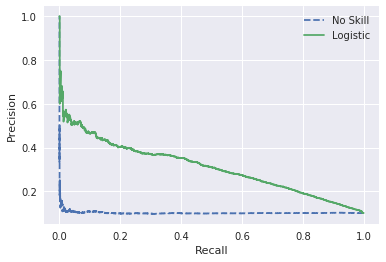

In [58]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, xdeep_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [59]:
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

AUC(PR):0.31031180298701566
